## **The task: classify people by solary level**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm.notebook import tqdm

## Download and prepare data

In [4]:
# download data
df =  pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=', ')
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [5]:
# give names to columns
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

# split features
numeric_indices = np.array([0, 2, 4, 10, 11, 12])
categorial_indices = np.array([1, 3, 5, 6, 7, 8, 9, 13])

df.columns = columns.split()

# clear data from nan
df = df.replace('?', np.nan)

df = df.dropna()

# prepare target
df['salary'] = df['salary'].apply((lambda x: x=='>50K'))

In [6]:
df.head()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,False


In [7]:
numeric_data = df[df.columns[numeric_indices]]

categorial_data = df[df.columns[categorial_indices]]
categorial_data.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States


One hot encoding

In [8]:
dummy_features = pd.get_dummies(categorial_data)

In [9]:
X = pd.concat([numeric_data, dummy_features], axis=1)
X_origin = df.iloc[:, :-1]
X.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,50,83311,13,0,0,13,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,38,215646,9,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,53,234721,7,0,0,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,28,338409,13,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37,284582,14,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [10]:
y = df['salary']

In [11]:
X.shape, X_origin.shape

((30161, 104), (30161, 14))

## Learn Models

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    train_size=0.8,
                                                    random_state=17)

In [13]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    '''
    The function drows mean score depending on the parameters grid.
    '''
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, 
                            param_grid=parameters,
                            cv=5, 
                            scoring='f1',
                            n_jobs=-1, 
                            verbose=10)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        plt.fill_between(grid, means - 2 * error, means + 2 * error, 
                         color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

Learn KNeighbors and DecisionTree

In [65]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [np.array(np.linspace(4, 30, 8), dtype='int'), np.arange(1, 30)]
param_scales = ['log', 'ordinary']

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   29.4s finished


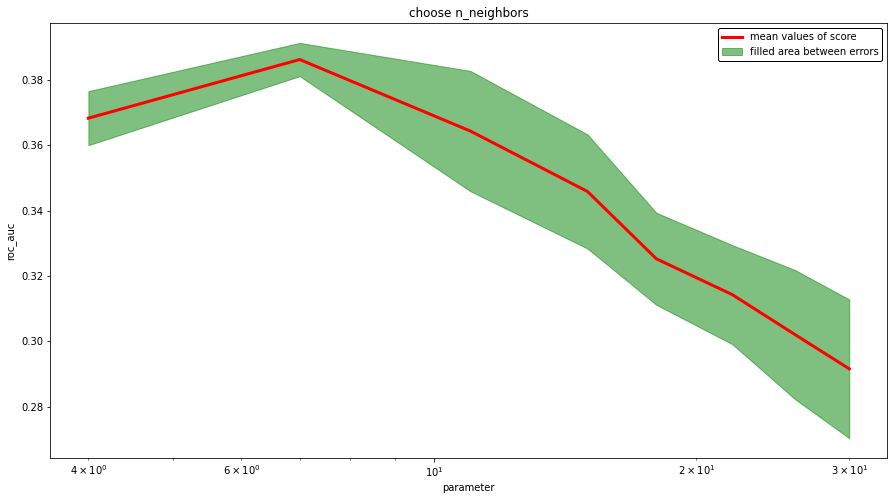

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0930s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 142 out of 145 | elapsed:   20.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:   20.6s finished


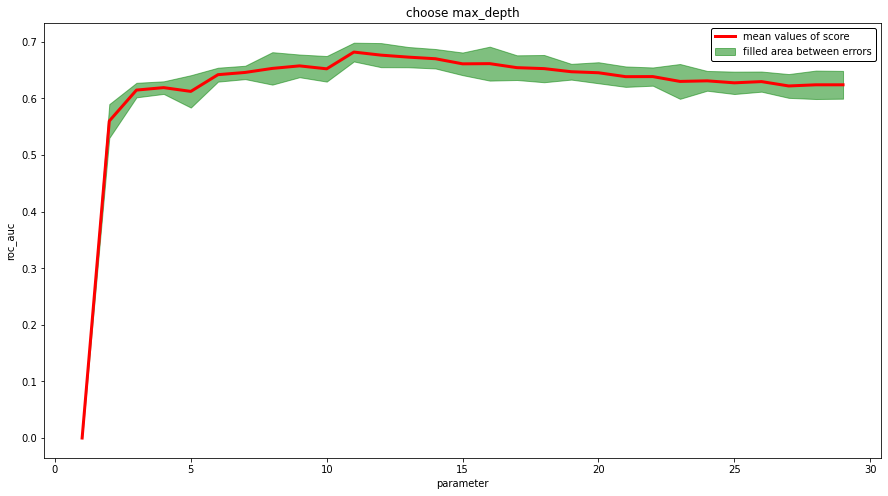

In [15]:
for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train, y_train, model, param_name, grid, param_scale)

In [67]:
# Normalize data for improve score
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  9.8min finished


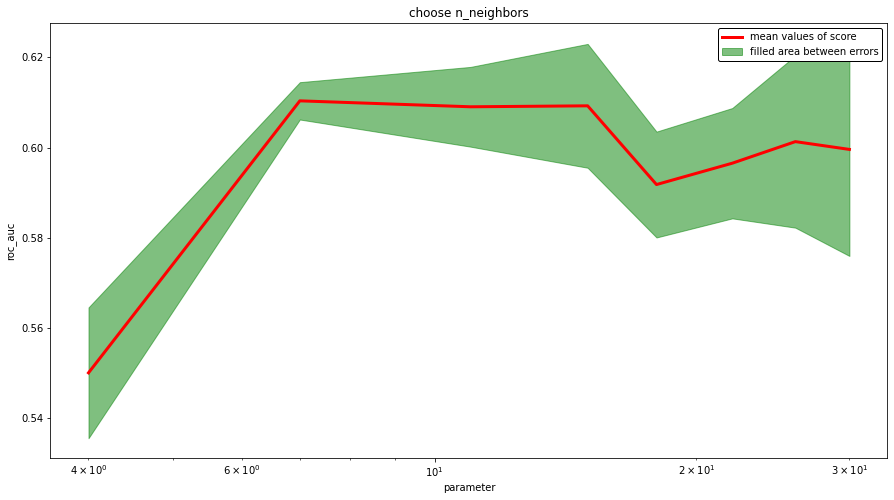

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0988s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 142 out of 145 | elapsed:   24.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:   24.7s finished


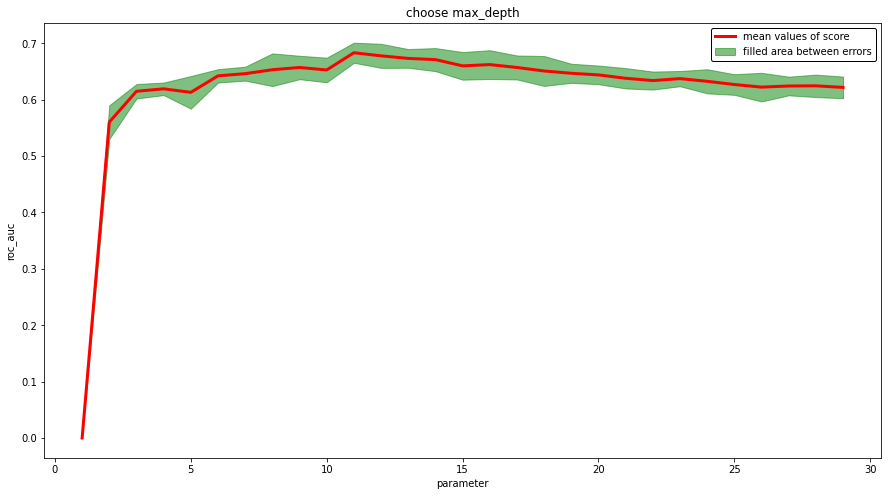

In [68]:
for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train_scaled, y_train, model, param_name, grid, param_scale)

Learn RandomForest

In [18]:
max_trees = 100

values = np.arange(max_trees) + 1

kf = KFold(n_splits=5, shuffle=True, random_state=17)

global_scores = []

for train_indices, val_indices in tqdm(kf.split(X_train), total=5):
    scores = []

    X_train_kf = X_train[train_indices]
    y_train_kf = y_train[train_indices]

    X_val_kf = X_train[val_indices]
    y_val_kf = y_train[val_indices]

    forest = RandomForestClassifier(n_estimators=max_trees)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_

    for number_of_trees in tqdm(values, leave=False):

        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)
        
        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]

        scores.append(roc_auc_score(y_val_kf, thinned_forest.predict_proba(X_val_kf)[:, 1]))

    scores = np.array(scores)

    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0)


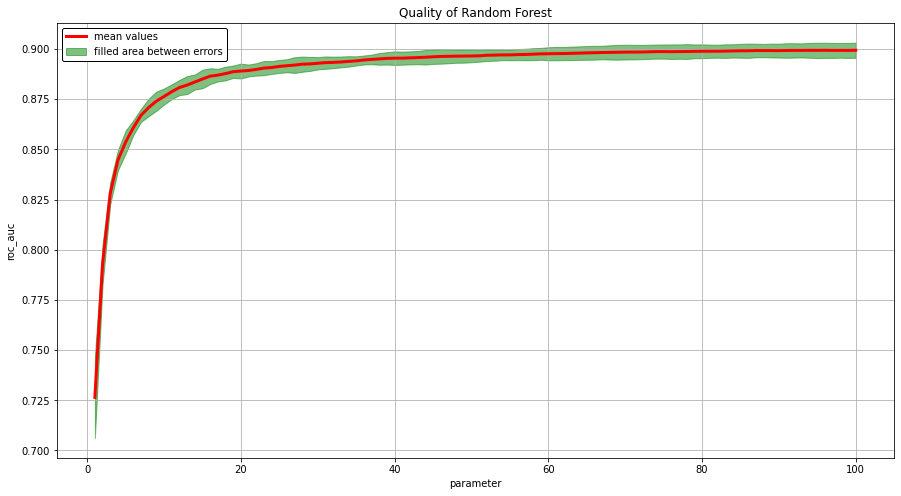

In [19]:
mean_cross_val_score = global_scores.mean(axis=0)
std_cross_val_score = global_scores.std(axis=0)

plt.figure(figsize=(15,8))
plt.title('Quality of Random Forest')

plt.plot(values, mean_cross_val_score, label='mean values', color='red', lw=3)
plt.fill_between(values, 
                 mean_cross_val_score - 2 * std_cross_val_score,
                 mean_cross_val_score + 2 * std_cross_val_score, 
                 color='green',
                 label='filled area between errors',
                 alpha=0.5)

legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
plt.xlabel('parameter')
plt.ylabel('roc_auc')
plt.grid()

plt.show()


In [25]:
model =  RandomForestClassifier(n_estimators=80, n_jobs=-1)

model.fit(X_train, y_train)
y_train_predicted = model.predict_proba(X_train)[:, 1]
y_test_predicted = model.predict_proba(X_test)[:, 1]

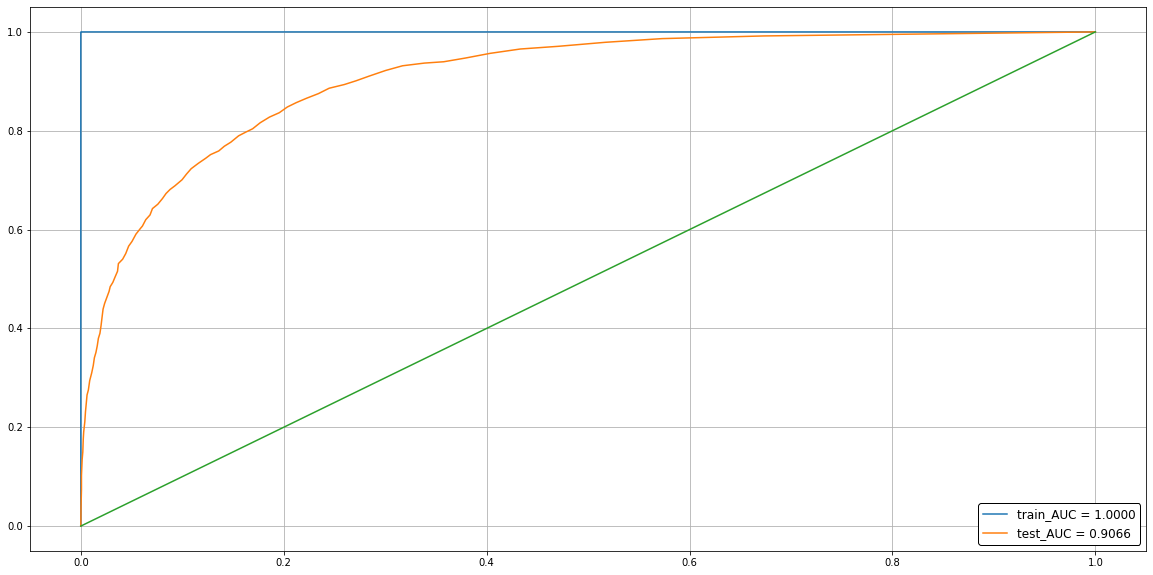

In [26]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label=('train_AUC = {:.4f}'.format(train_auc)))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label=('test_AUC = {:.4f}'.format(test_auc)))

legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.grid()

plt.show()


## Stacking

In [43]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):

    try:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict_proba(X_test)[:, 1]
    
    except Exception:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict(X_test)[:, 1]

In [45]:
models = []

models.append(KNeighborsClassifier(n_jobs=-1, n_neighbors=30))
models.append(LogisticRegression())
models.append(RandomForestClassifier(max_depth=3, n_estimators=80, n_jobs=-1))
models.append(RandomForestClassifier(max_depth=7, n_estimators=80, n_jobs=-1))
models.append(DecisionTreeClassifier(max_depth=8))

In [46]:
meta_features_train = np.zeros((X_train.shape[0], 0))
meta_features_test = np.zeros((X_test.shape[0], 0))

In [47]:
for model in tqdm(models):

    train, test = compute_meta_feature(model, X_train, X_test, y_train, 5)
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [48]:
stacking_model = LogisticRegression()
stacking_model.fit(meta_features_train, y_train)

y_train_predicted = stacking_model.predict_proba(meta_features_train)[:, 1]
y_test_predicted = stacking_model.predict_proba(meta_features_test)[:, 1]

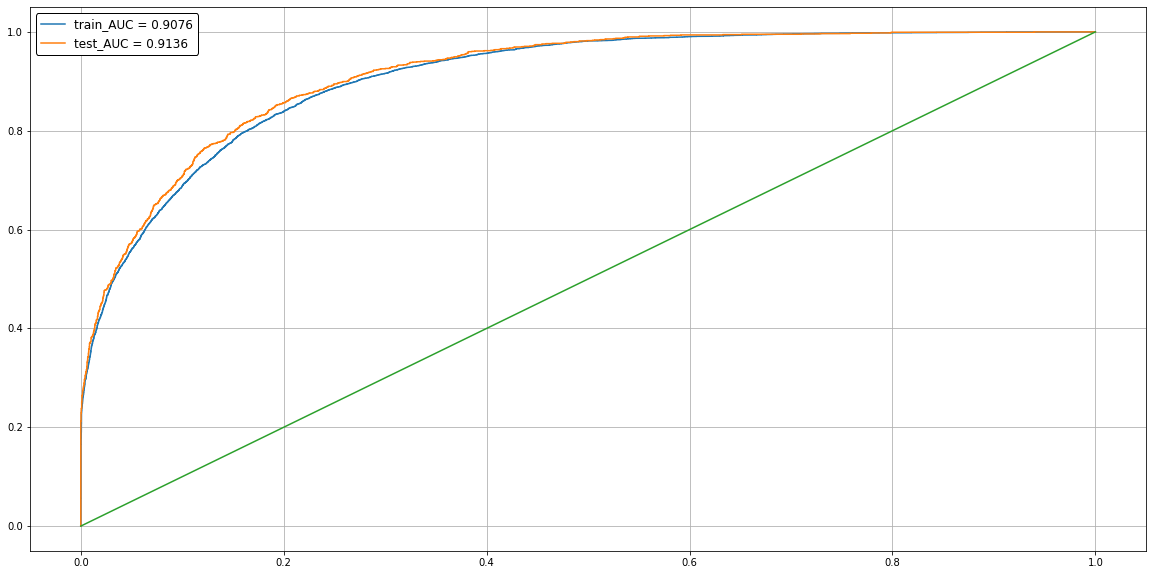

In [49]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label=('train_AUC = {:.4f}'.format(train_auc)))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label=('test_AUC = {:.4f}'.format(test_auc)))

legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.grid()

plt.show()


## Boosting

In [50]:
import xgboost

In [51]:
boosting_model = xgboost.XGBRFClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

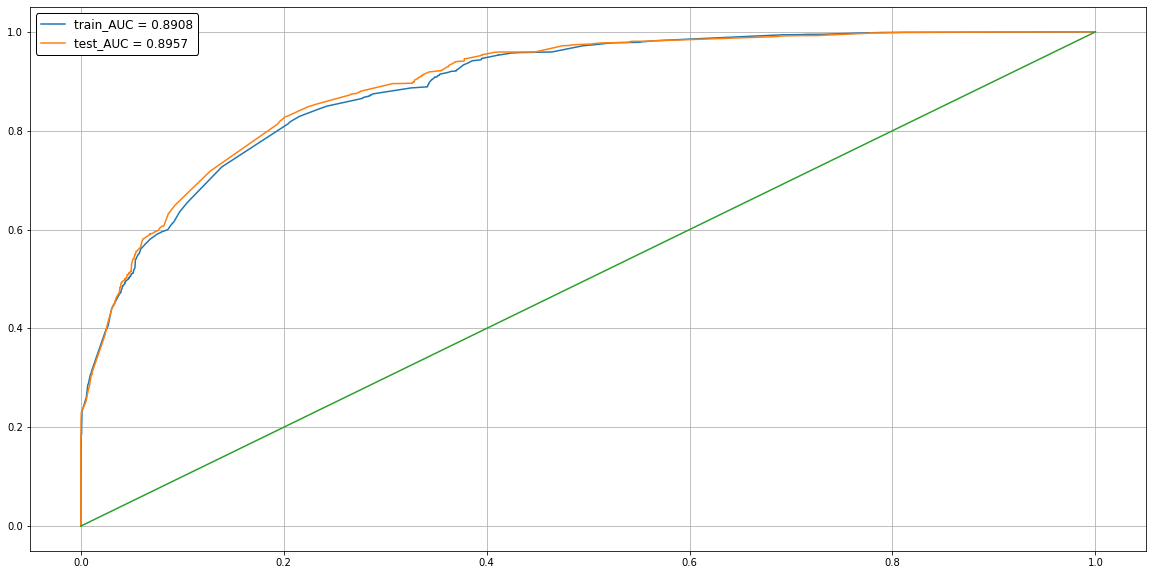

In [52]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label=('train_AUC = {:.4f}'.format(train_auc)))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label=('test_AUC = {:.4f}'.format(test_auc)))

legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.grid()

plt.show()


In [54]:
import catboost

In [55]:
X_train_origin, X_test_origin, _, _ = train_test_split(X_origin.values, y.values,
                                                       train_size=0.8,
                                                       random_state=17)


In [61]:
catboost_model = catboost.CatBoostClassifier(n_estimators=200,
                                             cat_features=categorial_indices,
                                             verbose=False)

catboost_model.fit(X_train_origin, y_train);

In [62]:
y_train_predicted = catboost_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = catboost_model.predict_proba(X_test_origin)[:, 1]

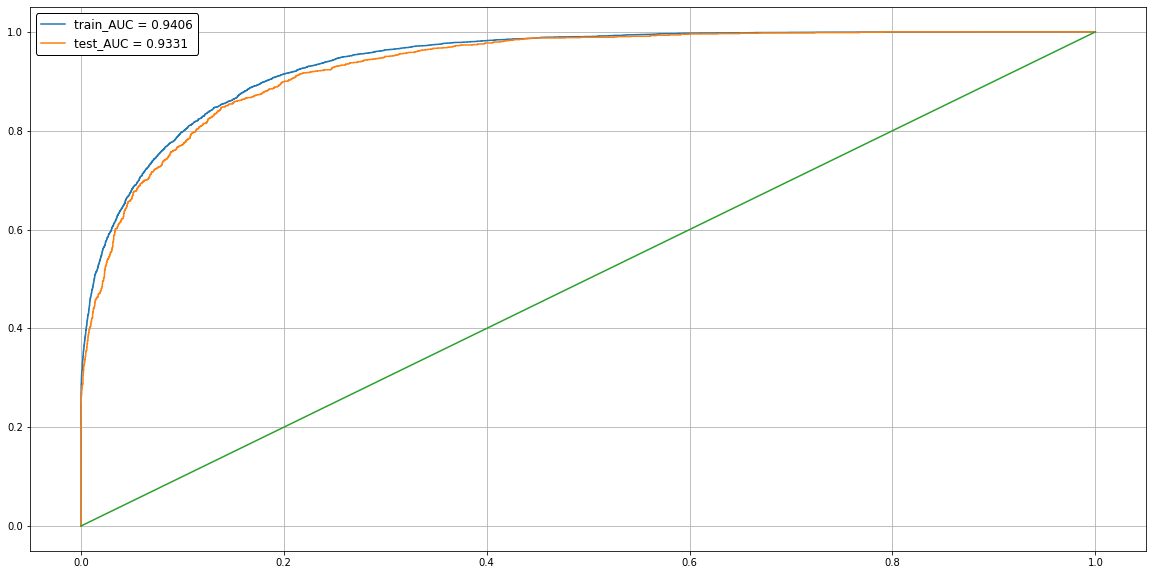

In [63]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label=('train_AUC = {:.4f}'.format(train_auc)))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label=('test_AUC = {:.4f}'.format(test_auc)))

legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.grid()

plt.show()

## **Total score: 93,31%**
